# Multiclass classification

The multiclass classification problem is a regression problem from an input $x \in {\cal X}$ to discrete labels $y\in {\cal Y}$, where ${\cal Y}$ is a discrete set of size $C$ bigger than two (for $C=2$ it is the more usual binary classification).

Labels are encoded in a one-hot fashion, that is if $C=4$ and $y=2$, we note $\bar{y} = [0,1,0,0]$.

The generative model for this problem consists of: 
 * $C$ latent functions $\mathbf{f} = [f_1,...,f_C]$ with an independent Gaussian Process prior
 * a deterministic function that builds a discrete distribution $\pi(\mathbf{f}) = [\pi_1(f_1),...,\pi_C(f_C)]$ from the latents such that $\sum_c \pi_c(f_c) = 1$ 
 * a discrete likelihood $p(y|\mathbf{f}) = Discrete(y;\pi(\mathbf{f})) = \prod_c \pi_c(f_c)^{\bar{y}_c}$

A typical example of $\pi$ is the softmax function: 

$$ \pi_c (f_c) \propto \exp( f_c)$$

Another convenient one is the robust max:
$$
\pi_c(\mathbf{f}) = \begin{cases} 1 - \epsilon, & \mbox{if } c = \arg \max_c f_c \\
 \epsilon /(C-1), & \mbox{ otherwise} \end{cases}
$$





In [3]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

from gpflow.test_util import notebook_niter
from multiclass_classification import plot_posterior_predictions, colors
from gpflow.utilities import print_summary

np.random.seed(0)

## Sampling from the GP multiclass generative model

### Declaring model parameters and input

In [4]:
# Number of functions and number of data points
C = 3
N = 100

# RBF kernel lengthscale
lengthscale = 0.1

# Jitter
jitter_eye = np.eye(N) * 1e-6

# Input
X = np.random.rand(N, 1)

### Sampling

In [5]:
# RBF kernel matrix
kernel = gpflow.kernels.RBF(lengthscale=lengthscale)
K = kernel.K(X) + jitter_eye

# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T

# Hard max observation
Y = np.argmax(f, 1).reshape(-1,).astype(int)

# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

### Plotting

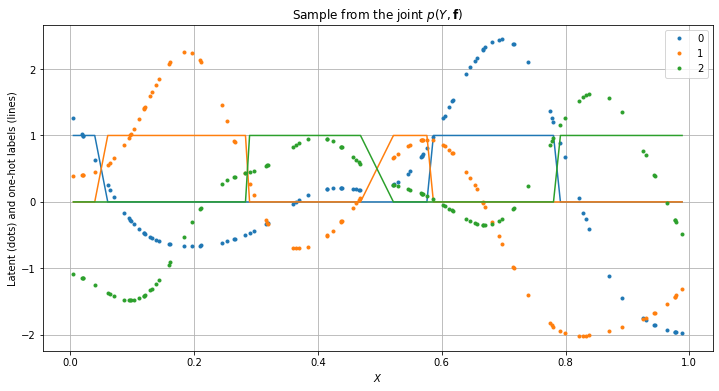

In [6]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):  
    plt.plot(X[order], f[order, c], '.', color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], '-', color=colors[c])


plt.legend()
plt.xlabel('$X$')
plt.ylabel('Latent (dots) and one-hot labels (lines)')
plt.title('Sample from the joint $p(Y, \mathbf{f})$')
plt.grid()
plt.show()

## Inference


Inference here consists of computing the posterior distribution over the latent functions given the data $p(\mathbf{f}|Y, X)$.

You can use different inference methods. Here we perform variational inference.
For a treatment of the multiclass classification problem using MCMC sampling, see [Markov Chain Monte Carlo (MCMC)](../advanced/mcmc.ipynb).



### Approximate inference: Sparse Variational Gaussian Process

#### Declaring the SVGP model (see [GPs for big data](../advanced/gps_for_big_data.ipynb))

In [7]:
# sum kernel: Matern32 + White
kern = gpflow.kernels.Matern32() + gpflow.kernels.White(variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(3, invlink=invlink)  # Multiclass likelihood
Z = X[::5].copy()  # inducing inputs

m = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variables=Z, num_latent=C, whiten=True, q_diag=True)

# Only train the variational parameters
m.kernel.variance.trainable = False
m.inducing_variables.trainable = False
print_summary(m)

name                             class      transform    trainable    shape    dtype    value
-------------------------------  ---------  -----------  -----------  -------  -------  --------------------
SVGP.kernel.variance             Parameter  Softplus     False        ()       float64  1.0
SVGP.kernel.lengthscale          Parameter  Softplus     True         ()       float64  0.1000000014901161
SVGP.likelihood.invlink.epsilon  Parameter  Sigmoid      False        ()       float64  0.001000000047497451
SVGP.inducing_variables.Z        Parameter               True         (20, 1)  float64  [[0.5488135...
SVGP.q_mu                        Parameter               True         (20, 3)  float64  [[0., 0., 0....
SVGP.q_sqrt                      Parameter  Softplus     True         (20, 3)  float64  [[1., 1., 1....


### Running inference

In [8]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return m.neg_log_marginal_likelihood(X, Y)

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
name                             class      transform    trainable    shape    dtype    value
-------------------------------  ---------  -----------  -----------  -------  -------  ----------------------------------------------------
SVGP.kernel.variance             Parameter  Softplus     False        ()       float64  1.0
SVGP.kernel.lengthscale          Parameter  Softplus     True         ()       float64  0.08247091583596704
SVGP.likelihood.invlink.epsilon  Parameter  Sigmoid      False        ()       float64  0.001000000047497451
SVGP.inducing_variables.Z        Parameter               True         (20, 1)  float64  [[0.57024207...
SVGP.q_mu                        Parameter               True         (20, 3)  float64  [[2.62741837e-01, 7.63782140e-01, -1.02652398e+00...
SVGP.q_sqrt                      Parameter  Softplus     True         (20, 3)  float64  [[0.1

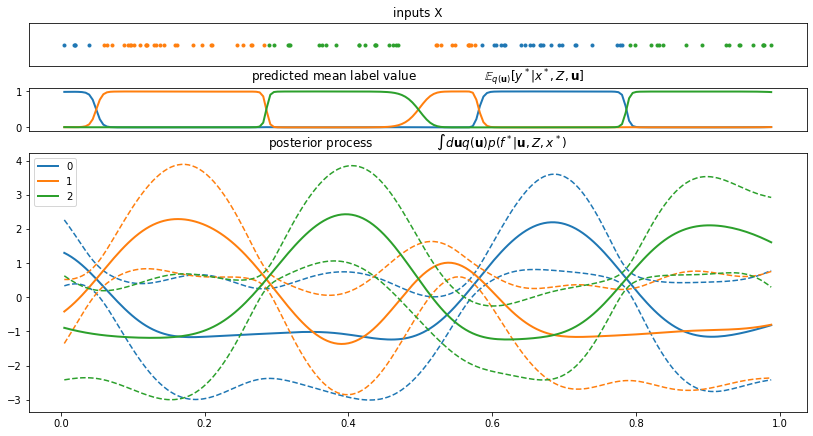

In [9]:
plot_posterior_predictions(m, X, Y)